# Figure 6: Internal Variability Related to Coupling

In [1]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress, ttest_ind
from typing import Tuple

# Plotting Utils

In [60]:
yr = 12*5
axis_fontsize = 12
title_fontsize = 14

def create_panel_a(ax, x6, y6, x5: list = [], y5: list = [], vline=0) -> None:
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    CMIP6_label = "CMIP6"
    
    ax.scatter(x6, y6, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP6_label)

    # Multimodel mean
    mmm = np.mean([*x5, *x6])


    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))

    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    if p < .05: 
        sig = '*'
    else: 
        sig = ''
    print(r, p)

    x = np.array(sorted(x))
    ax.plot(x, x*slope+intercept, color="black")
    # ax.legend(loc="upper left", fontsize=fontsize)
    ax.set_title(f"r={r}{sig}", loc="right", fontweight="bold", fontsize=title_fontsize)
    
    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))
    ax.set_xlim(xmin-borderx, xmax+borderx)
    ax.set_ylim(ymin-bordery, ymax+bordery)

    # Vertical line for avg and std of obs
    ax.vlines(np.mean(vline), ymin=ymin-bordery, ymax=ymax+bordery, color="navy")
    ax.fill_between(x=[np.mean(vline) - np.std(vline), np.mean(vline) + np.std(vline)], y1=ymin-bordery, y2=ymax+bordery,color="navy", alpha=.25)

    # Add Model Vertical Lines
    ax.vlines(mmm, ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], label='_nolegend_', alpha=.5, linewidth=2, zorder=0) 
    # ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=-1, y2=2.5, color="black", alpha=.25)
    ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=np.min(y)*5-100, y2=np.max(y)*5+100, color="black", alpha=.25)

    # Add horizontal sigma lines
    sig_mmm = mmm*slope+intercept
    sig_obs = np.mean(vline)*slope+intercept
    hline_width = 3
    ax.hlines(y=sig_mmm, xmin=xmin-borderx, xmax=mmm, color="black", linewidth=hline_width)
    ax.hlines(y=sig_obs, xmin=xmin-borderx, xmax=np.mean(vline), color="orange", linewidth=hline_width)

    ax.text(s=f"{np.around(sig_mmm, 2)}", x=xmin-borderx*.95, y=sig_mmm + sig_mmm*.025, color="black", fontsize=12, fontweight="bold")
    ax.text(s=f"{np.around(sig_obs, 2)}", x=xmin-borderx*.95, y=sig_obs + sig_mmm*.025, color="orange", fontsize=12, fontweight="bold")

In [34]:
def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_{name}.nc")
    
    grads = np.zeros((data.model.size, int((len(data.time) - window) / step)))
    grads.fill(np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        grads[:,j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values

    # Convert to xarray
    da =  xr.DataArray(grads*window, dims=("model", "time"), coords={"model": data.model, "time": np.arange(grads.shape[1])})
    if save:
        da.to_netcdf(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_{name}.nc")
    
    return da

# Load Data

In [37]:
DATA_ROOT = "/home/espinosa10/SO-EP-teleconnection/Data"

# 30-year Trends
sst_ept_cmip6 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc")
sst_ept_cmip5 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc")
sst_ept_cmip = xr.concat([sst_ept_cmip6, sst_ept_cmip5], dim="model")

sst_so_cmip6 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc")
sst_so_cmip5 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc")
sst_so_cmip = xr.concat([sst_so_cmip6, sst_so_cmip5], dim="model")

# dEPT/dSO at variance timescales: CMIP
rvalues_so_ept_coupling = xr.open_dataset(os.path.join(DATA_ROOT, "so_ept_coupling.nc"))
# dEPT/dSO at variance timescale: Obs
obs_sst_so_ept_reg = xr.open_dataset(os.path.join(DATA_ROOT, "obs_so_ept_coupling.nc"))

# Load Walker Circulation
walker_anomaly = xr.open_dataset(os.path.join(DATA_ROOT, "walker_anomaly.nc"))["walker"]
# Load WE Gradient
WE_sst_anomaly = xr.open_dataset(os.path.join(DATA_ROOT, "WE_sst_anomaly.nc"))["WE_sst"]

# Calculate 30-year rolling trends for Walker Circulation and W-E Tropical Pacific Gradient
walker_30yr_trends = calculate_rolling_gradient(walker_anomaly, window = 12*30, name="walker", save=True)
WE_30yr_trends = calculate_rolling_gradient(WE_sst_anomaly, window = 12*30, name="WE_sst", save=True)

# Figure 6

0.63 0.0
0.499 0.0
0.579 0.0


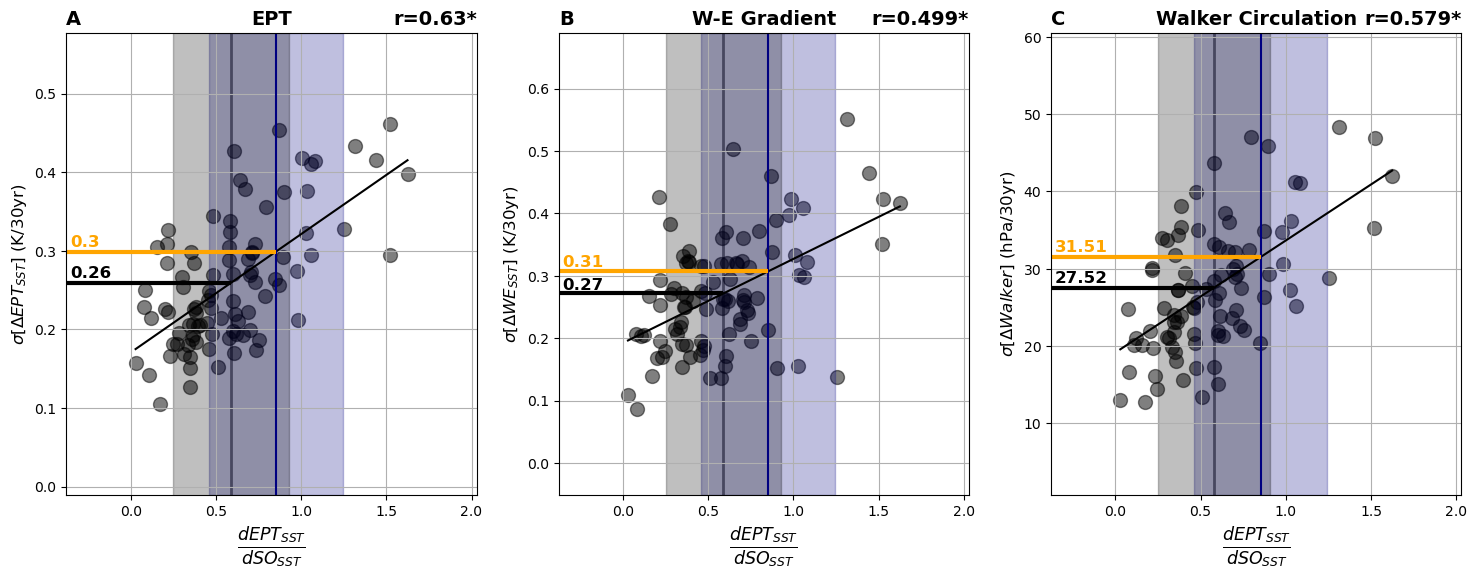

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Panel A
create_panel_a(
    axes[0],
    rvalues_so_ept_coupling.reg.sel(years=yr),
    sst_ept_cmip.std("time"),
    vline=obs_sst_so_ept_reg.sel(years=yr).reg.values,
)
axes[0].grid()
axes[0].set_ylabel(r"$\sigma[\Delta EPT_{SST}]$ (K/30yr)", fontsize=axis_fontsize)
axes[0].set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5)
axes[0].set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
axes[0].set_title("EPT", fontweight="bold", fontsize=title_fontsize)

# Panel B
rval, WE_30yr_trends_std = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=yr), WE_30yr_trends.std("time"))
create_panel_a(
    axes[1],
    rval.values, 
    WE_30yr_trends_std.values,
    vline=obs_sst_so_ept_reg.sel(years=yr).reg.values,
)
axes[1].grid()
axes[1].set_ylabel(r"$\sigma[\Delta WE_{SST}]$ (K/30yr)", fontsize=axis_fontsize)
axes[1].set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5)
axes[1].set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
axes[1].set_title("W-E Gradient", fontweight="bold", fontsize=title_fontsize)

# Panel C
rval, walker_30yr_trends_std = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=yr), walker_30yr_trends.std("time"))
create_panel_a(
    axes[2],
    rval.values, 
    walker_30yr_trends_std.values,
    vline=obs_sst_so_ept_reg.sel(years=yr).reg.values,
)
axes[2].grid()
axes[2].set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5)
axes[2].set_ylabel(r"$\sigma[\Delta Walker]$ (hPa/30yr)", fontsize=axis_fontsize)
axes[2].set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)
axes[2].set_title("Walker Circulation", fontweight="bold", fontsize=title_fontsize)

#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_6.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_6.pdf", dpi=300, bbox_inches="tight")